In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score


c:\Users\natal\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('input/spotify_songs.csv', sep=',')

songs = df[['playlist_genre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]
print(songs.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   playlist_genre    32833 non-null  object 
 1   danceability      32833 non-null  float64
 2   energy            32833 non-null  float64
 3   key               32833 non-null  int64  
 4   loudness          32833 non-null  float64
 5   mode              32833 non-null  int64  
 6   speechiness       32833 non-null  float64
 7   acousticness      32833 non-null  float64
 8   instrumentalness  32833 non-null  float64
 9   liveness          32833 non-null  float64
 10  valence           32833 non-null  float64
 11  tempo             32833 non-null  float64
 12  duration_ms       32833 non-null  int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 3.3+ MB
None


In [3]:
songs.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000
mean,0.654850,0.698619,5.374471,-6.719499,0.565711,0.107068,0.175334,0.084747,0.190176,0.510561,120.881132,225799.811622
std,0.145085,0.180910,3.611657,2.988436,0.495671,0.101314,0.219633,0.224230,0.154317,0.233146,26.903624,59834.006182
min,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,99.960000,187819.000000
50%,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000,216000.000000
75%,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918000,253585.000000
max,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000


In [3]:
# Remove duplicates
duplicates = songs.duplicated()
print("Number of duplicate rows: ", duplicates.sum())

songs_no_duplicates = songs.drop_duplicates()


Number of duplicate rows:  3041


We have performed tests with and without removing duplicated rows. Turns out leaving duplicates yields much better result (almost 5% improvement for some models).

In [5]:
print("Total number of songs: ", len(songs))
print(songs['playlist_genre'].value_counts())

Total number of songs:  32833
playlist_genre
edm      6043
rap      5746
pop      5507
r&b      5431
latin    5155
rock     4951
Name: count, dtype: int64


In [4]:
min = songs['playlist_genre'].value_counts().min()
# Take only min songs from each genre
songs_grouped = songs.groupby('playlist_genre').head(min)

In [5]:
map_genres = {genre: i for i, genre in enumerate(songs_grouped['playlist_genre'].unique())}
map_genres 

{'pop': 0, 'rap': 1, 'rock': 2, 'latin': 3, 'r&b': 4, 'edm': 5}

In [6]:
songs_data_non_normalized = songs_grouped.drop('playlist_genre', axis=1)
songs_target = songs_grouped['playlist_genre']
songs_target = songs_target.map(map_genres)

# Normalize data to 0-1 range
songs_data = (songs_data_non_normalized - songs_data_non_normalized.min()) / (songs_data_non_normalized.max() - songs_data_non_normalized.min())

songs_data_train, songs_data_test, songs_target_train, songs_target_test = train_test_split(songs_data, songs_target, test_size=0.3, random_state=0)
songs_data_test, songs_data_val, songs_target_test, songs_target_val = train_test_split(songs_data_test, songs_target_test, test_size=0.5, random_state=0)

print("Training set size: ", len(songs_data_train))
print("Test set size: ", len(songs_data_test))
print("Validation set size: ", len(songs_data_val))

Training set size:  20794
Test set size:  4456
Validation set size:  4456


In [7]:
# only train-test split (for cross validation)
songs_data_train2, songs_data_test2, songs_target_train2, songs_target_test2 = train_test_split(songs_data, songs_target, test_size=0.15, random_state=0)

print("Training set size: ", len(songs_data_train2))
print("Test set size: ", len(songs_data_test2))

Training set size:  25250
Test set size:  4456


# Data analysis

In [8]:
cols = ['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms']

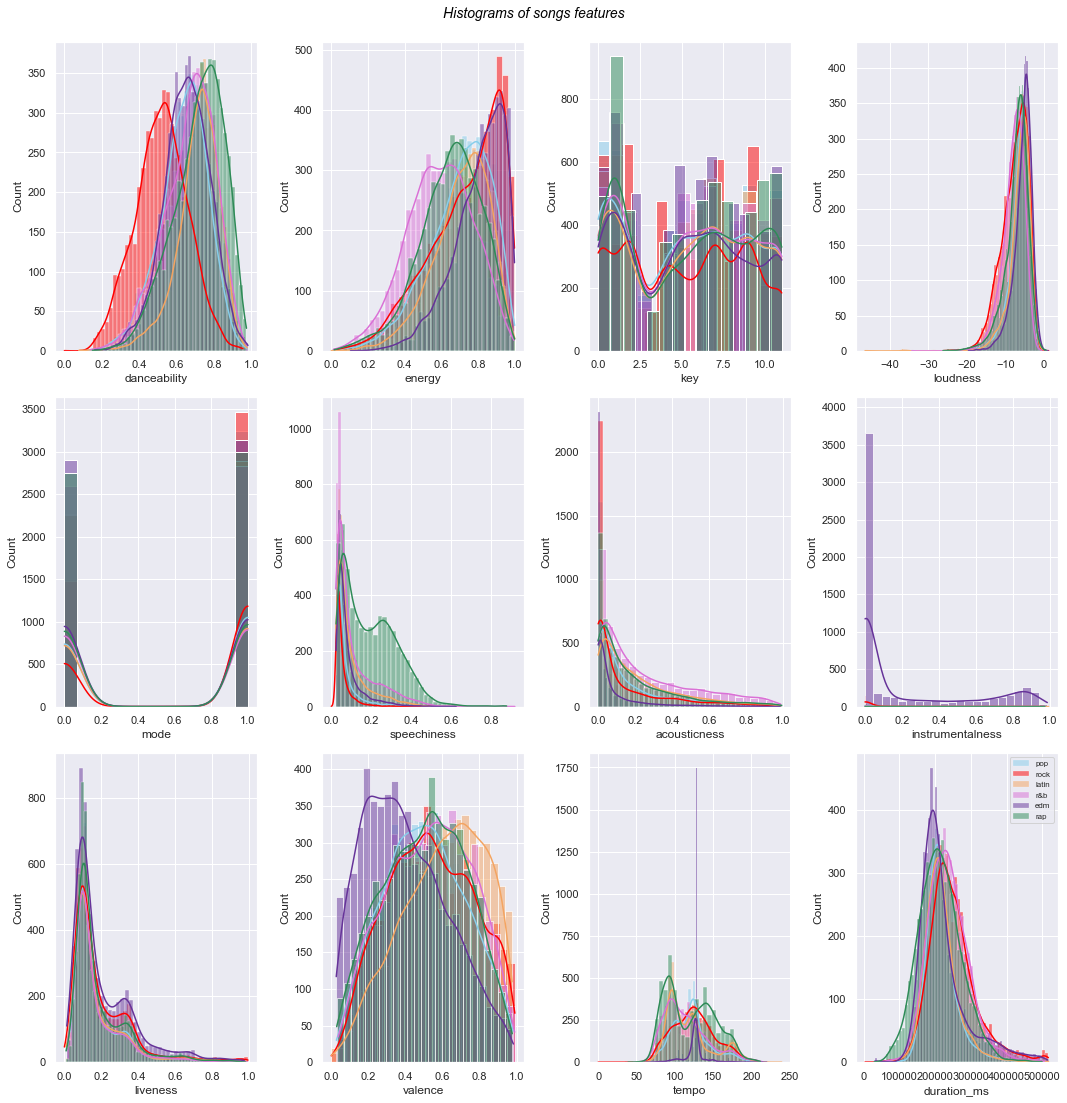

In [16]:
# normalized data
pop_df = songs[songs['playlist_genre']=='pop']
rock_df = songs[songs['playlist_genre']=='rock']
latin_df = songs[songs['playlist_genre']=='latin']
r_and_b_df = songs[songs['playlist_genre']=='r&b']
edm_df = songs[songs['playlist_genre']=='edm']
rap_df = songs[songs['playlist_genre']=='rap']

num=0
for col in cols:
    num+=1
    plt.subplot(3,4, num)
    plt.rcParams['figure.figsize'] = [15, 15]
    #sns.set(style="darkgrid")

    sns.histplot(data=pop_df,x=col, color="skyblue", label="pop", kde=True)
    sns.histplot(data=rock_df,x=col, color="red", label="rock", kde=True)
    sns.histplot(data=latin_df,x=col, color="sandybrown", label="latin", kde=True)
    sns.histplot(data=r_and_b_df,x=col, color="orchid", label="r&b", kde=True)
    sns.histplot(data=edm_df,x=col, color="rebeccapurple", label="edm", kde=True)
    sns.histplot(data=rap_df,x=col, color="seagreen", label="rap", kde=True)

plt.tight_layout()
# general title
plt.suptitle("Histograms of songs features", fontsize=14, fontweight=0, color='black', style='italic', y=1.02)
plt.legend(loc="upper right",fontsize='9') #bbox_to_anchor=(1, 0)
#sns.move_legend(loc="lower center", bbox_to_anchor=(.5, 0), ncol=6, title=None, frameon=False)
plt.show()

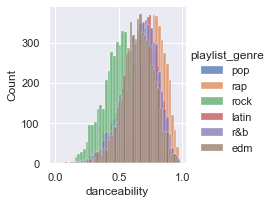

In [17]:
# different way to do the histogram (it is here just in case I want to change sth)
g = sns.FacetGrid(songs, hue="playlist_genre")
g.map(sns.histplot, "danceability") # kde=True
g.add_legend()

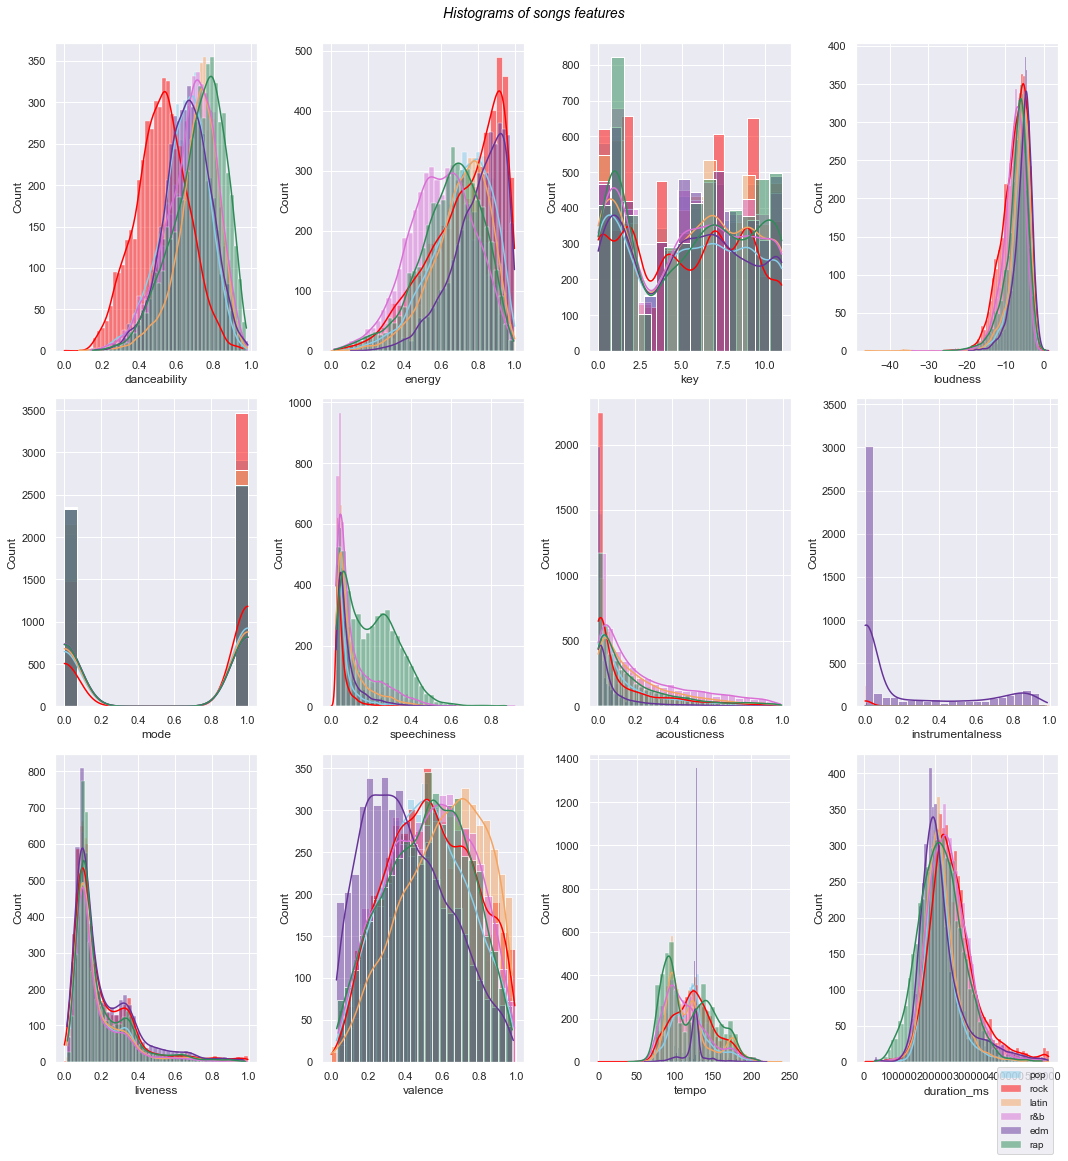

In [20]:
# without normalization
pop_df = songs_grouped[songs_grouped['playlist_genre']=='pop']
rock_df = songs_grouped[songs_grouped['playlist_genre']=='rock']
latin_df = songs_grouped[songs_grouped['playlist_genre']=='latin']
r_and_b_df = songs_grouped[songs_grouped['playlist_genre']=='r&b']
edm_df = songs_grouped[songs_grouped['playlist_genre']=='edm']
rap_df = songs_grouped[songs_grouped['playlist_genre']=='rap']

num=0
for col in cols:
    num+=1
    plt.subplot(3,4, num)
    plt.rcParams['figure.figsize'] = [15, 15]
    #sns.set(style="darkgrid")

    sns.histplot(data=pop_df,x=col, color="skyblue", label="pop", kde=True)
    sns.histplot(data=rock_df,x=col, color="red", label="rock", kde=True)
    sns.histplot(data=latin_df,x=col, color="sandybrown", label="latin", kde=True)
    sns.histplot(data=r_and_b_df,x=col, color="orchid", label="r&b", kde=True)
    sns.histplot(data=edm_df,x=col, color="rebeccapurple", label="edm", kde=True)
    sns.histplot(data=rap_df,x=col, color="seagreen", label="rap", kde=True)
    
plt.tight_layout()
# general title
plt.suptitle("Histograms of songs features", fontsize=14, fontweight=0, color='black', style='italic', y=1.02)
plt.legend(loc="upper right",fontsize='10')
plt.show()

# Models

## KNeighborsClassifier

In [10]:
# KNeighborsClassifier
results = []
for k in tqdm(np.arange(1,35)):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(songs_data_train, songs_target_train)

    y_pred = knn_model.predict(songs_data_val)
    accuracy = accuracy_score(songs_target_val, y_pred)
    results.append({'k':k, 'accuracy': accuracy})
                   
results_df = pd.DataFrame(results)
results_df.sort_values('accuracy', ascending=False)

  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [00:22<00:00,  1.54it/s]


,k,accuracy
24,25,0.471050
32,33,0.470377
27,28,0.470153
21,22,0.469928
20,21,0.469928
33,34,0.469479
22,23,0.469479
31,32,0.469031
30,31,0.469031
26,27,0.468582


In [47]:
# accuracy on test set
knn_model = KNeighborsClassifier(n_neighbors=25)
knn_model.fit(songs_data_train, songs_target_train)
y_pred = knn_model.predict(songs_data_test)
accuracy = accuracy_score(songs_target_test, y_pred)
print(accuracy)

0.4723967684021544


In [32]:
# cross validation
res = []
for k in np.arange(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    er = cross_val_score(knn_model,songs_data_train2,songs_target_train2,cv=5)
    res.append({'K':k, 'err_rate': er})

In [33]:
results = list(map(lambda x: (x['K'], x['err_rate'].mean()), res))
results_df = pd.DataFrame(results)
results_df.loc[results_df[1]==results_df[1].max()]

,0,1
22,23,0.466772


In [48]:
# accuracy on test set
knn_model = KNeighborsClassifier(n_neighbors=23)
knn_model.fit(songs_data_train2, songs_target_train2)
y_pred = knn_model.predict(songs_data_test2)
accuracy = accuracy_score(songs_target_test2, y_pred)
print(accuracy)

0.46925493716337524


### KNN on not normalized data

In [15]:
songs_data_train_nn, songs_data_test_nn, songs_target_train_nn, songs_target_test_nn = train_test_split(songs_data_non_normalized, songs_target, test_size=0.3, random_state=0)
songs_data_test_nn, songs_data_val_nn, songs_target_test_nn, songs_target_val_nn = train_test_split(songs_data_test_nn, songs_target_test_nn, test_size=0.5, random_state=0)

In [16]:
results = []
for k in tqdm(np.arange(1,35)):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(songs_data_train_nn, songs_target_train_nn)

    y_pred = knn_model.predict(songs_data_val_nn)
    accuracy = accuracy_score(songs_target_val_nn, y_pred)
    results.append({'k':k, 'accuracy': accuracy})
                   
results_df = pd.DataFrame(results)
results_df.loc[results_df['accuracy']==results_df['accuracy'].max()]

100%|██████████| 34/34 [00:06<00:00,  5.01it/s]


,k,accuracy
0,1,0.290171


In [49]:
# accuracy on test set
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(songs_data_train_nn, songs_target_train_nn)
y_pred = knn_model.predict(songs_data_test_nn)
accuracy = accuracy_score(songs_target_test_nn, y_pred)
print(accuracy)

0.2888240574506284


As we see, results for not normalized data are much worse.

## Naive bayes classifier

In [18]:
# Naive bayes classifier
naive_bayes_model = GaussianNB()

naive_bayes_model.fit(songs_data_train, songs_target_train)
y_pred = naive_bayes_model.predict(songs_data_val)
accuracy = accuracy_score(songs_target_val, y_pred)

print(accuracy)

0.4506283662477558


In [19]:
# accuracy on test set
naive_bayes_model = GaussianNB()

naive_bayes_model.fit(songs_data_train2, songs_target_train2)
y_pred = naive_bayes_model.predict(songs_data_test2)
accuracy = accuracy_score(songs_target_test2, y_pred)

print(accuracy)

0.44350718783414517


Each feature has the same influence on the decision.

## Decision tree

In [20]:
# Decision tree
decision_tree_model = DecisionTreeClassifier()

param_grid = {
    'max_depth': [7,9,11],
    'min_samples_leaf': [3,4,5],
    'min_samples_split': [6,7,8]
}

grid_search = GridSearchCV(decision_tree_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(songs_data_train, songs_target_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best params:", best_params)

y_pred = best_model.predict(songs_data_val)
accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

Best params: {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 6}
0.4643177737881508


In [21]:
# feature importances
best_model.feature_importances_

array([0.17231034, 0.08777891, 0.00565915, 0.07505336, 0.00211726,
       0.19339656, 0.05211473, 0.09632431, 0.00705703, 0.06262628,
       0.17007464, 0.07548741])

In [22]:
feature_importances_dt = pd.Series(best_model.feature_importances_, index=songs_data_train.columns)
feature_importances_dt

danceability        0.172310
energy              0.087779
key                 0.005659
loudness            0.075053
mode                0.002117
speechiness         0.193397
acousticness        0.052115
instrumentalness    0.096324
liveness            0.007057
valence             0.062626
tempo               0.170075
duration_ms         0.075487
dtype: float64

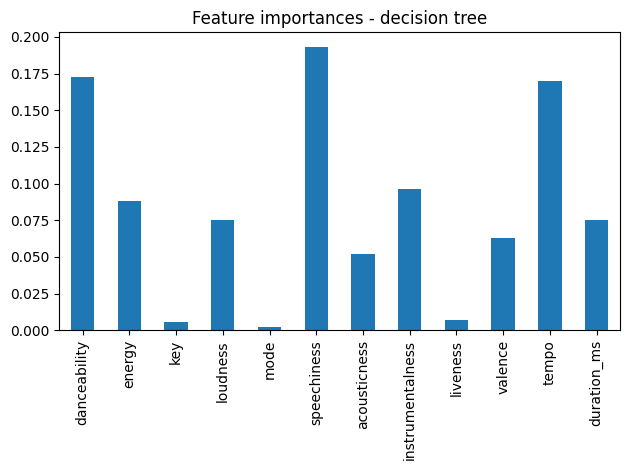

In [23]:
fig, ax = plt.subplots()
feature_importances_dt.plot.bar(ax=ax)
ax.set_title("Feature importances - decision tree")
fig.tight_layout()

## Random forest

In [24]:
# Random forest
random_forest_model = RandomForestClassifier(n_estimators=105, random_state=42)
random_forest_model.fit(songs_data_train, songs_target_train)
y_pred = random_forest_model.predict(songs_data_val)
accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

# hyperparameter tunning - kilka opcji: sprawdzić najpeirw zakresy, potem albo sprynie wybrać odpowiednie albo random

0.547576301615799


In [25]:
# feature importances
random_forest_model.feature_importances_

array([0.11707867, 0.09406571, 0.04441596, 0.08675772, 0.01335281,
       0.12172192, 0.08929889, 0.07396318, 0.06634473, 0.08991702,
       0.1127258 , 0.09035759])

In [26]:
feature_importances_rf = pd.Series(random_forest_model.feature_importances_, index=songs_data_train.columns)
feature_importances_rf

danceability        0.117079
energy              0.094066
key                 0.044416
loudness            0.086758
mode                0.013353
speechiness         0.121722
acousticness        0.089299
instrumentalness    0.073963
liveness            0.066345
valence             0.089917
tempo               0.112726
duration_ms         0.090358
dtype: float64

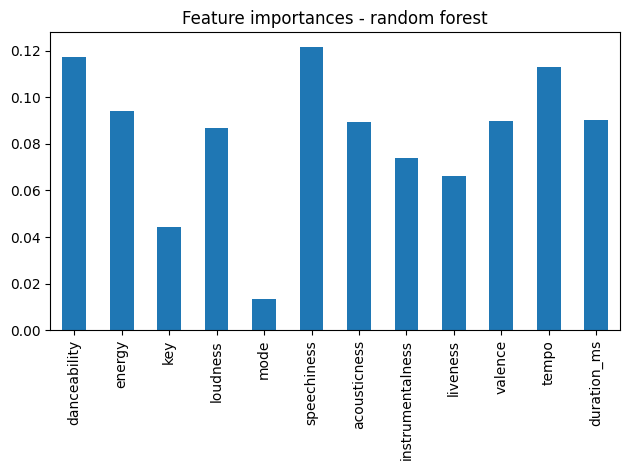

In [27]:
fig, ax = plt.subplots()
feature_importances_rf.plot.bar(ax=ax)
ax.set_title("Feature importances - random forest")
fig.tight_layout()

## KNN on important features

Let's try to consider only the features with high `feature importance` in both random forest and decision trees and use them for the KNN classifier

In [28]:
feature_importances = feature_importances_dt + feature_importances_rf
print(feature_importances.sort_values(ascending=False))

speechiness         0.315118
danceability        0.289389
tempo               0.282800
energy              0.181845
instrumentalness    0.170287
duration_ms         0.165845
loudness            0.161811
valence             0.152543
acousticness        0.141414
liveness            0.073402
key                 0.050075
mode                0.015470
dtype: float64


In [39]:
res = []
for n_features in tqdm(np.arange(1, len(feature_importances))):
    important_columns = feature_importances.sort_values(ascending=False).index[:n_features]
    important_data = songs_data[important_columns]
    important_data_train, important_data_test, important_target_train, important_target_test = train_test_split(important_data, songs_target, test_size=0.15, random_state=0)
    # cross validation
    for k in np.arange(1,40):
        knn_model = KNeighborsClassifier(n_neighbors=k)
        er = cross_val_score(knn_model,important_data_train,important_target_train,cv=5)
        res.append({'n_feat': n_features, 'K':k, 'err_rate': er.mean()})


100%|██████████| 11/11 [16:06<00:00, 87.89s/it] 


In [41]:
# find best k for each number of features
results_df = pd.DataFrame(res)
results_df = results_df.sort_values('err_rate', ascending=False)
results_df = results_df.groupby('n_feat').head(1)
results_df = results_df.reset_index(drop=True)
results_df

,n_feat,K,err_rate
0,9,32,0.501109
1,8,38,0.499446
2,10,30,0.495129
3,7,33,0.486812
4,11,38,0.472356
5,6,33,0.472317
6,5,23,0.458059
7,4,27,0.447208
8,3,36,0.423525
9,2,35,0.344317


In [42]:
important_columns = feature_importances.sort_values(ascending=False).index[:9]
important_data = songs_data_train[important_columns]
important_data_train, important_data_test, important_target_train, important_target_test = train_test_split(important_data, songs_target_train, test_size=0.15, random_state=0)

knn_model = KNeighborsClassifier(n_neighbors=32)
knn_model.fit(important_data_train, important_target_train)
y_pred = knn_model.predict(important_data_test)
accuracy = accuracy_score(important_target_test, y_pred)
print(accuracy)

0.503525641025641


## Support Vector Machine

In [43]:
# Support Vector Machine
clf = svm.SVC(decision_function_shape='ovr', kernel='poly', degree=4)
clf.fit(songs_data_train, songs_target_train)
y_pred = clf.predict(songs_data_val)

accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

0.5175044883303411


## Multiclass Logistic Regression

In [44]:
mlr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=1000)
mlr.fit(songs_data_train, songs_target_train)
y_pred = mlr.predict(songs_data_val)

accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

0.4762118491921005


## AdaBoost


In [45]:
# AdaBoost
base_model = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(base_model, n_estimators=50, learning_rate=1, random_state=42)
adaboost_model.fit(songs_data_train, songs_target_train)
y_pred = adaboost_model.predict(songs_data_val)


accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

0.4903500897666068


## Bootstrap Aggregating

In [46]:
#Bagging (Bootstrap Aggregating)
base_model = DecisionTreeClassifier()
bagging_model = BaggingClassifier(base_model, n_estimators=50, random_state=42)
bagging_model.fit(songs_data_train, songs_target_train)
y_pred = bagging_model.predict(songs_data_val)

accuracy = accuracy_score(songs_target_val, y_pred)
print(accuracy)

0.5412926391382405


## TO DO
XGBoost